In [1]:
# Import Packages
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor



In [2]:
# Import Data
df_train = pd.read_csv("data/technical/sales_train.csv")
df_shops = pd.read_csv("data/info/shops.csv")
df_items = pd.read_csv("data/info/items.csv")
df_test = pd.read_csv("data/technical/test.csv")

# Autoplot for Reference

In [3]:
# https://www.kaggle.com/yasserhessein/predict-future-sales-using-4-algorithms-regression

from autoviz.AutoViz_Class import AutoViz_Class

def plot_all():
    AV = AutoViz_Class()
    target='item_price'
    df = AV.AutoViz(filename="",sep=',', depVar=target, dfte=df_train, header=0, verbose=1,
                    lowess=False, chart_format='svg', max_rows_analyzed=150000, max_cols_analyzed=30)

# plot_all()

Imported AutoViz_Class version: 0.0.81. Call using:
    from autoviz.AutoViz_Class import AutoViz_Class
    AV = AutoViz_Class()
    AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=0,
                            lowess=False,chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30)
Note: verbose=0 or 1 generates charts and displays them in your local Jupyter notebook.
      verbose=2 saves plots in your local machine under AutoViz_Plots directory and does not display charts.


# Prepare to format time data

In [4]:
# store the amount of items to verify it later on
og_df_size = df_train.shape[0]

In [5]:
# transform to df date format
df_train['date'] = pd.to_datetime(df_train['date'], dayfirst=True)
# convert date to month
df_train['date'] = df_train['date'].apply(lambda x: x.strftime('%Y-%m'))

# create new df and verify that nothing gets lost
df_all_sales = pd.DataFrame(df_train, columns=['date', 'item_cnt_day'])
print("Column entry match" if df_all_sales.shape[0] == og_df_size else "Warning!")

df_all_sales.head()

Column entry match


,date,item_cnt_day
0,2013-01,1.0
1,2013-01,1.0
2,2013-01,-1.0
3,2013-01,1.0
4,2013-01,1.0


# Get an overview of the all the items sold over time

In [6]:
print(df_all_sales.head())
df_all_sales.set_index('date', inplace=True)
df_all_sales_summed = df_all_sales.sum(level='date')
# print(df_all_sales_summed)
# print(df_all_sales_summed.shape)

      date  item_cnt_day
0  2013-01           1.0
1  2013-01           1.0
2  2013-01          -1.0
3  2013-01           1.0
4  2013-01           1.0


<AxesSubplot:xlabel='date'>

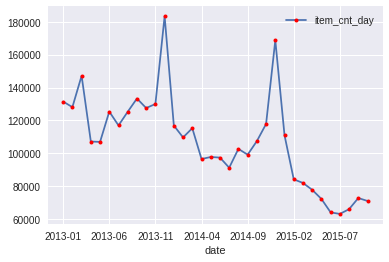

In [7]:
# set the default marker style for all plots
%matplotlib inline
plt.rcParams['lines.marker'] = 'o'
plt.rcParams['lines.markersize'] = 4
plt.rcParams['lines.markerfacecolor'] = 'red'

# plot it
df_all_sales_summed.plot()

# Check how much money is spent in each month

In [8]:
# create new df and verify that nothing gets lost
df_compute_money_spend = pd.DataFrame(df_train, columns=['date', 'item_cnt_day', 'item_price'])

# compute the turnover of that data entry
df_compute_money_spend['turnover'] = df_compute_money_spend.apply(lambda x: x['item_cnt_day'] * x['item_price'], axis=1)

In [9]:
# verify the output
df_compute_money_spend.head()

,date,item_cnt_day,item_price,turnover
0,2013-01,1.0,999.00,999.00
1,2013-01,1.0,899.00,899.00
2,2013-01,-1.0,899.00,-899.00
3,2013-01,1.0,1709.05,1709.05
4,2013-01,1.0,1099.00,1099.00


In [10]:
# drop columns that are no longer needed
df_compute_money_spend = df_compute_money_spend.drop(['item_cnt_day', 'item_price'], axis=1)

In [11]:
df_compute_money_spend.set_index('date', inplace=True)
df_compute_money_spend_summed = df_compute_money_spend.sum(level='date')
# print(df_compute_money_spend_summed)
# print(df_compute_money_spend_summed.shape)

<AxesSubplot:xlabel='date'>

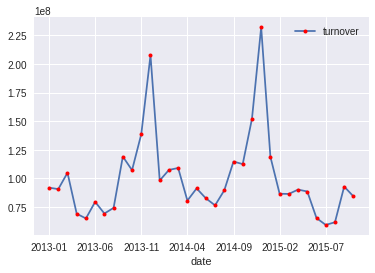

In [12]:
df_compute_money_spend_summed.plot()

# Sales vs. Turnover Side-by-Side comparison

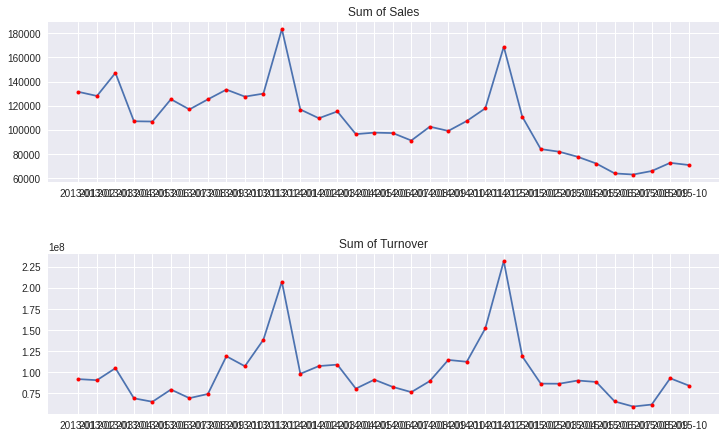

<Figure size 792x504 with 0 Axes>

In [13]:
plt.rcParams['figure.figsize'] = [11, 7]  # shouldn't be done like that but it works, not sure why

plt.subplot(2, 1, 1) # row 1, column 2, count 1
plt.plot(df_all_sales_summed)
plt.title("Sum of Sales")
plt.subplot(2, 1, 2) # row 1, column 2, count 2
plt.plot(df_compute_money_spend_summed)
plt.title("Sum of Turnover")

# space between the plots
plt.tight_layout(4)

plt.show(plt.figure(figsize=(11,7)))

# Get an overview of the items sold per shop


In [14]:
df_all_sales_per_shop = pd.DataFrame(df_train, columns=['date', 'item_cnt_day', 'shop_id'])
print("Column entry match" if df_all_sales_per_shop.shape[0] == og_df_size else "Warning!")

df_all_sales_per_shop.set_index(['date', 'shop_id'], inplace=True)

Column entry match


In [15]:
df_all_sales_per_shop_summed = df_all_sales_per_shop.sum(level=['date', 'shop_id'])
print(df_all_sales_per_shop_summed)

                 item_cnt_day
date    shop_id              
2013-01 59             2017.0
        25             8215.0
        24             1768.0
        23             1948.0
        19             3038.0
...                       ...
2015-10 28             3018.0
        26             1409.0
        25             6247.0
        24             1227.0
        21             1912.0

[1586 rows x 1 columns]


In [16]:

df_all_sales_per_shop_summed = df_all_sales_per_shop_summed.swaplevel(i='shop_id', j='date')
print(df_all_sales_per_shop_summed.head())
print(df_all_sales_per_shop_summed.shape)

# foo = df_all_sales_per_shop_summed.groupby(by='date')
# foo.head()
# print(foo.describe)

# df_all_sales_per_shop_summed

                 item_cnt_day
shop_id date                 
59      2013-01        2017.0
25      2013-01        8215.0
24      2013-01        1768.0
23      2013-01        1948.0
19      2013-01        3038.0
(1586, 1)


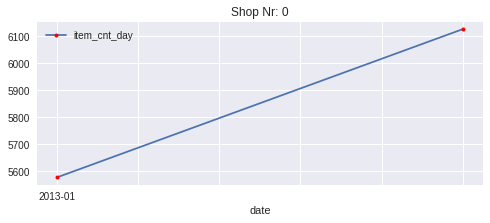

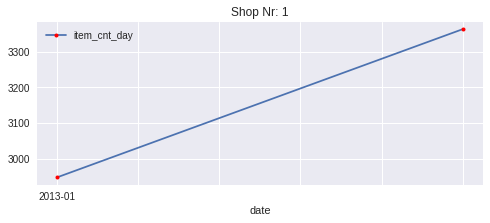

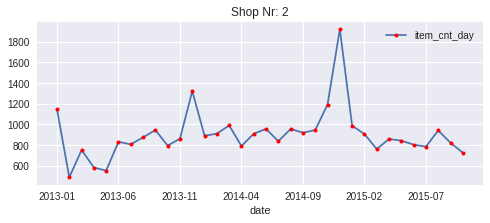

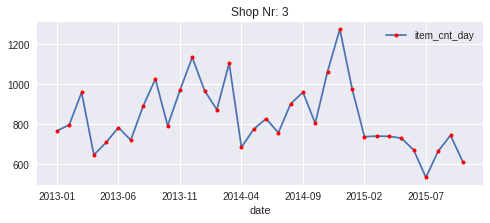

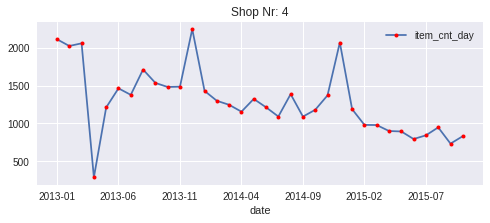

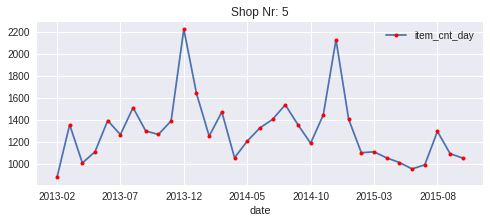

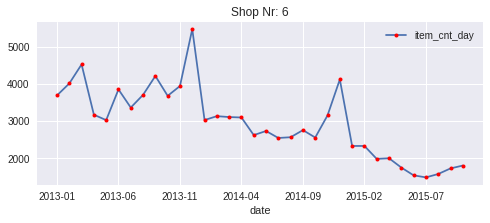

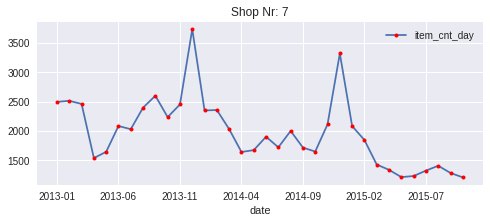

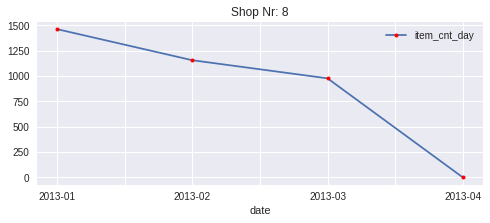

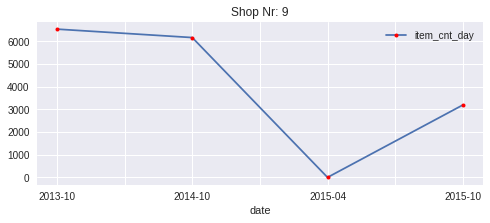

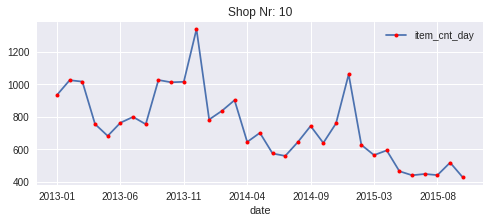

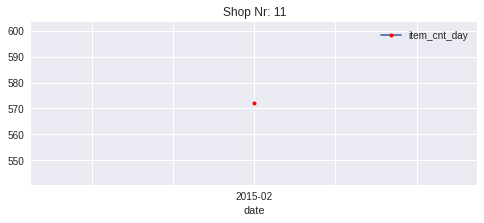

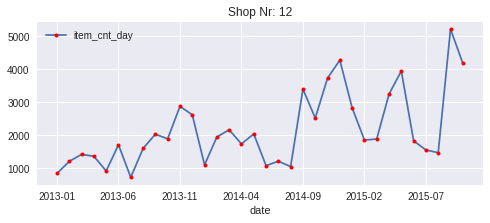

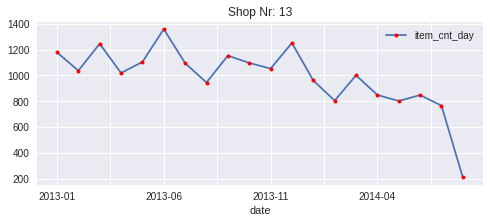

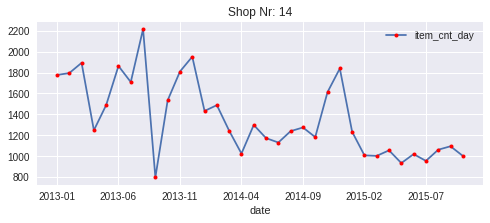

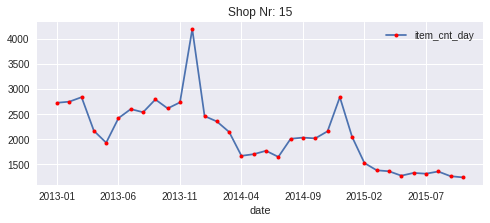

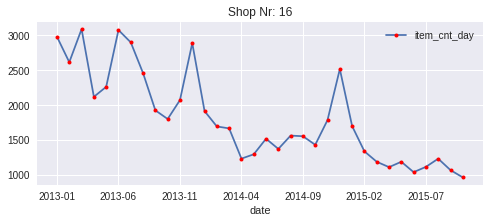

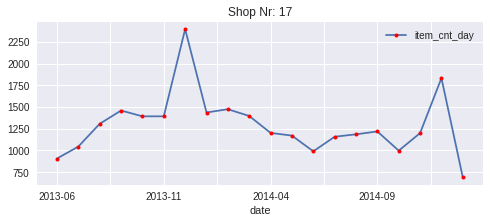

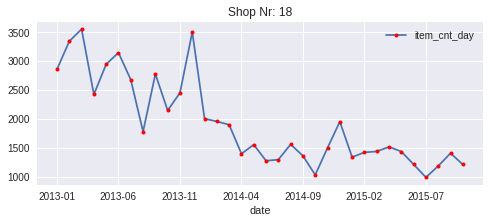

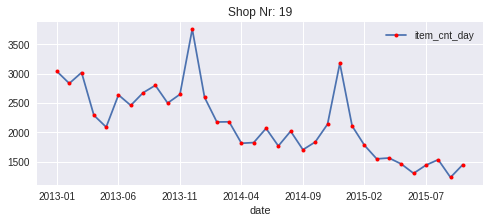

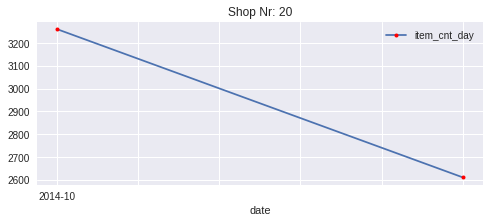

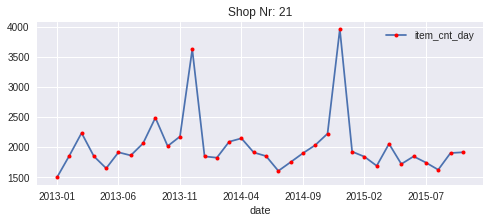

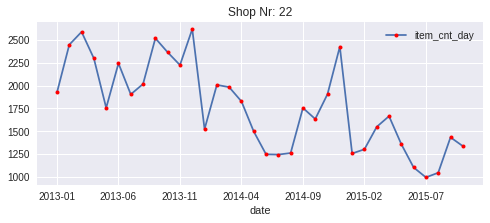

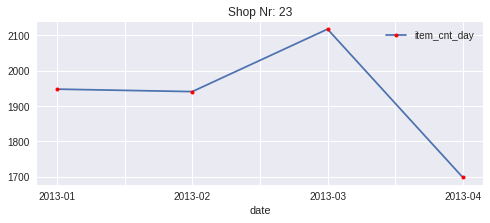

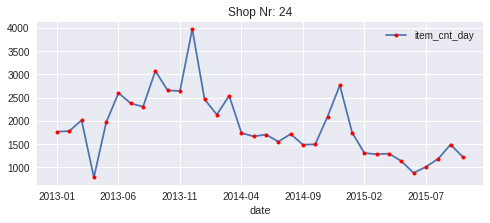

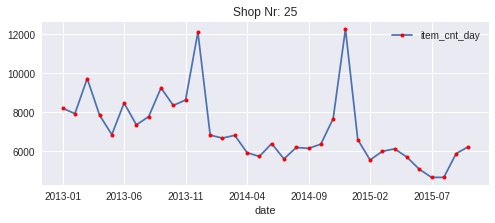

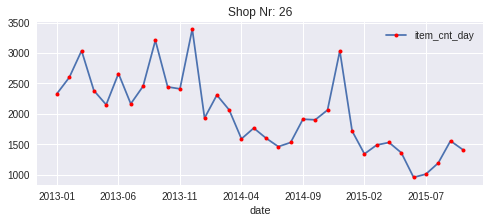

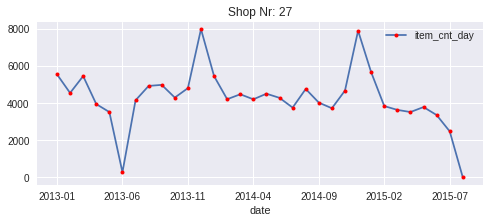

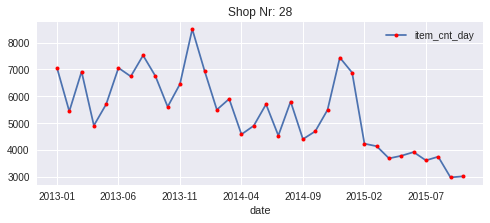

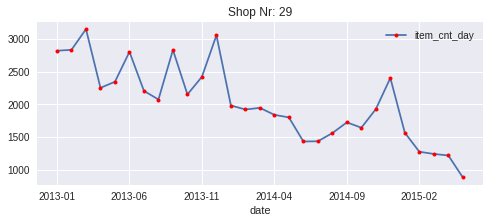

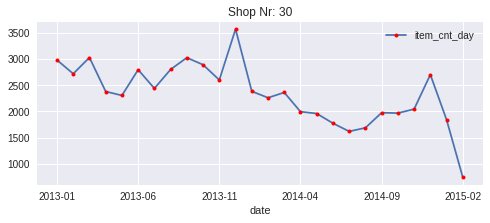

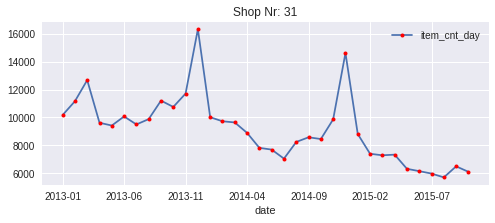

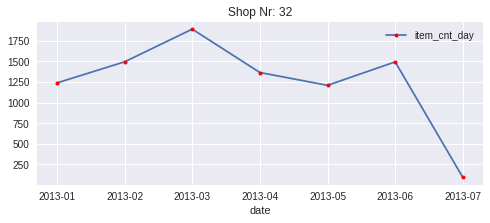

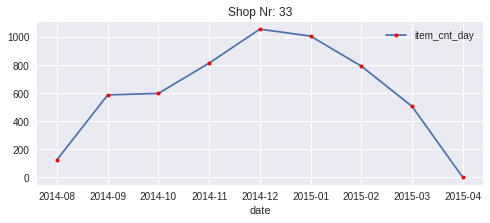

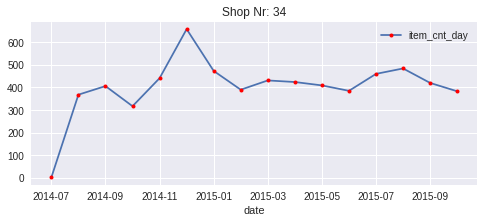

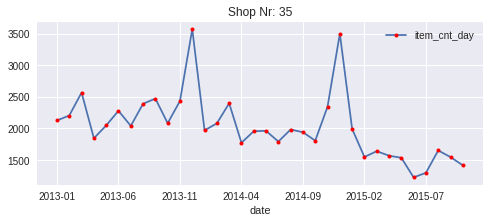

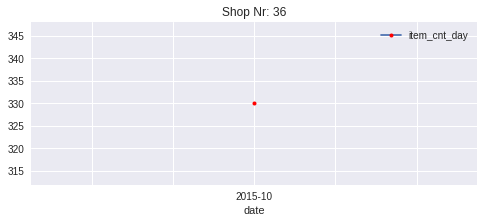

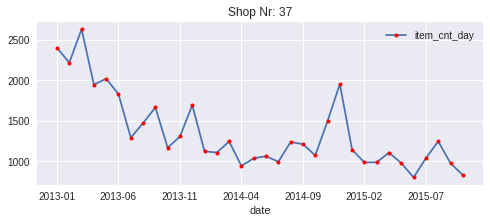

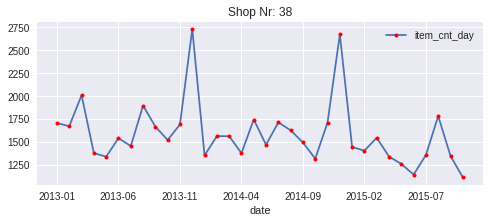

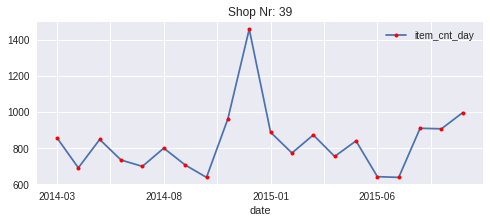

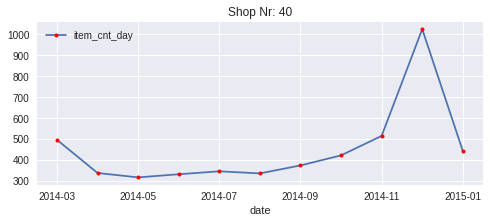

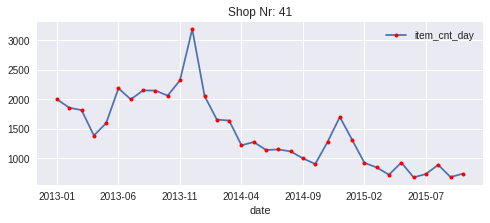

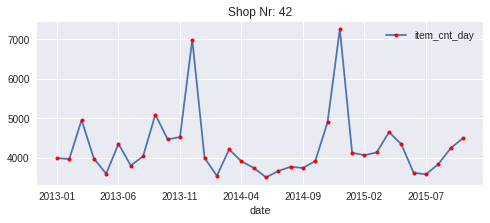

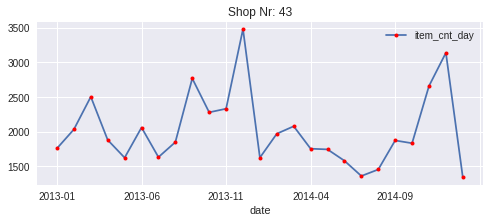

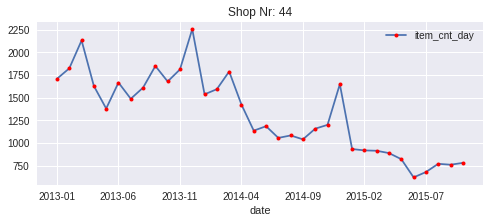

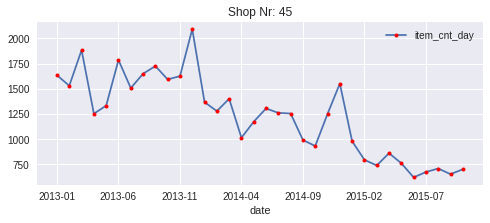

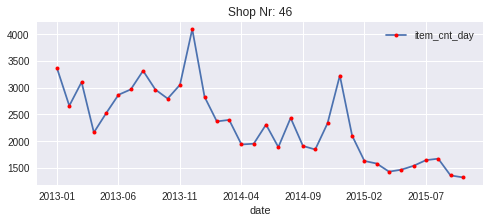

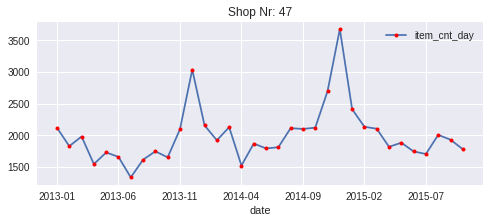

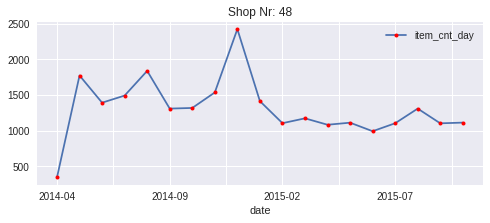

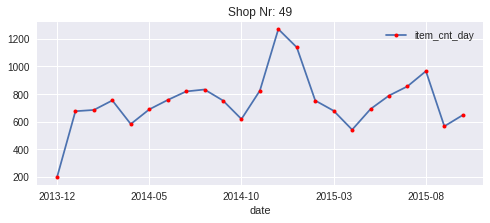

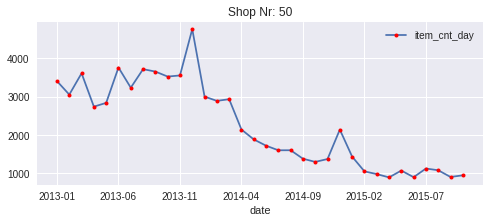

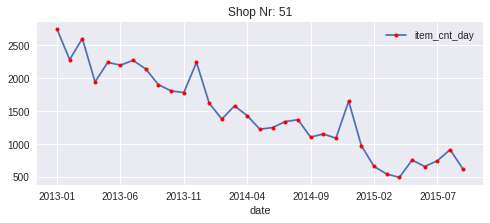

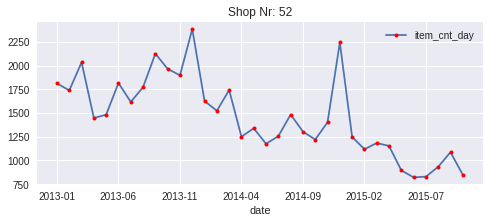

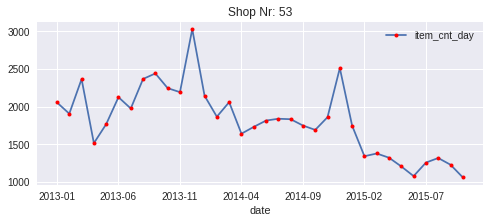

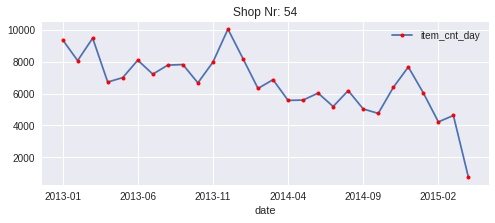

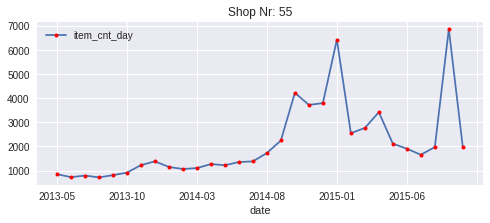

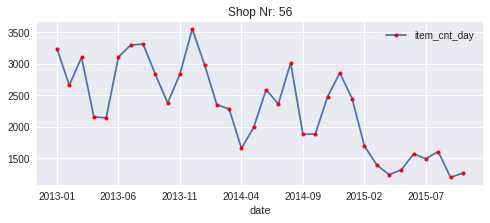

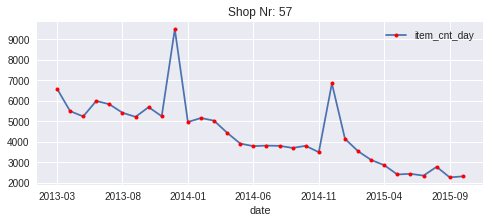

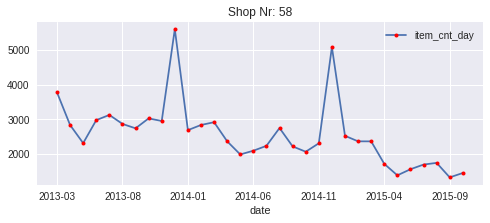

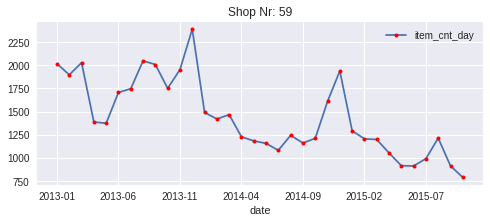

In [17]:
plt.rcParams['figure.figsize'] = [8, 3]  # shouldnt be done like that but it works, not sure why

# print all the graphs

df = df_all_sales_per_shop_summed
df.reset_index(inplace=True, level=['shop_id'])
# print(df.head())
# print(df.shape)

# df_this_shop = df.loc[df['shop_id'] == 52]
# print(df_this_shop)
for shop in df_shops['shop_id']:
    df_this_shop = df.loc[df['shop_id'] == shop]
    df_this_shop = df_this_shop.drop(['shop_id'], axis=1)
    plot = df_this_shop.plot()
    plot.set_title(f"Shop Nr: {shop}")
    # print(df_this_shop)

# Get an overview of all the item categories sold


In [18]:
# create new dataframe and merge with item info to get the item category id
df_all_sales_per_category = pd.DataFrame(df_train, columns=['date', 'item_cnt_day', 'item_id'])
df_all_sales_per_category = df_all_sales_per_category.set_index('item_id').join(df_items.set_index('item_id'))

In [19]:
# verify column size matches and drop the item name
print("Column entry match" if df_all_sales_per_category.shape[0] == og_df_size else "Warning!")
df_all_sales_per_category = df_all_sales_per_category.drop(['item_name'], axis=1)
df_all_sales_per_category.head()

Column entry match


,date,item_cnt_day,item_category_id
item_id,,,
0,2014-09,1.0,40
1,2014-04,1.0,76
1,2014-04,1.0,76
1,2014-07,1.0,76
1,2014-08,1.0,76


In [20]:
# reset index and get rid of the item id
df_all_sales_per_category = df_all_sales_per_category.reset_index()
df_all_sales_per_category = df_all_sales_per_category.drop(['item_id'], axis=1)
df_all_sales_per_category.head()

,date,item_cnt_day,item_category_id
0,2014-09,1.0,40
1,2014-04,1.0,76
2,2014-04,1.0,76
3,2014-07,1.0,76
4,2014-08,1.0,76


In [21]:
# sum up all items sold in function of the item category and the date
df_all_sales_per_category.set_index(['date', 'item_category_id'], inplace=True)
df_all_sales_per_category_summed = df_all_sales_per_category.sum(level=['date', 'item_category_id'])
print(df_all_sales_per_category_summed)

                          item_cnt_day
date    item_category_id              
2014-09 40                     12748.0
2014-04 76                       164.0
2014-07 76                       218.0
2014-08 76                       254.0
2014-09 76                       267.0
...                                ...
2015-06 83                       258.0
2015-07 83                       298.0
2015-08 83                       293.0
2015-09 83                       277.0
2015-10 83                       348.0

[2077 rows x 1 columns]


In [22]:
# remove the duplicates and re-sort a new item category df
df_item_categories = df_items['item_category_id']
df_item_categories = df_item_categories.drop_duplicates()
df_item_categories = df_item_categories.sort_values()

df_item_categories

5441      0
5606      1
5570      2
5652      3
1955      4
         ..
17717    79
9244     80
13346    81
13344    82
22085    83
Name: item_category_id, Length: 84, dtype: int64

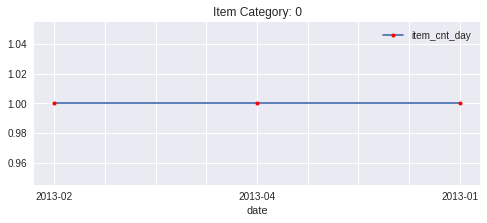

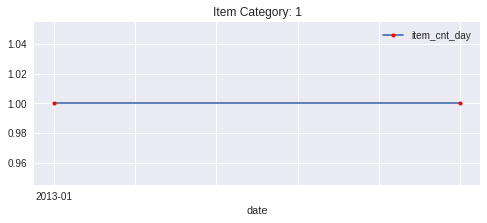

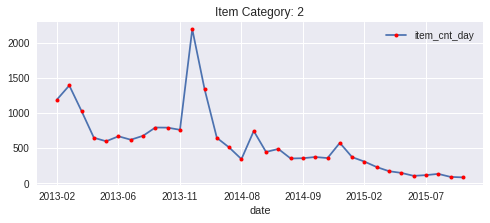

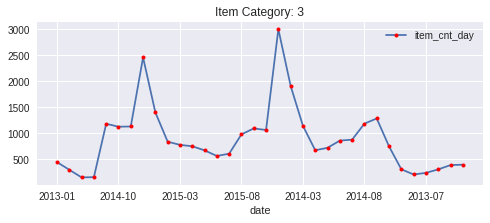

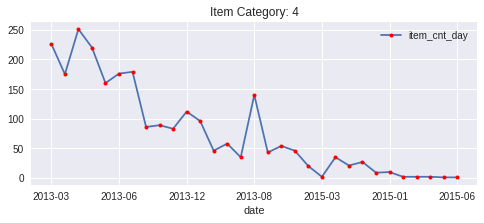

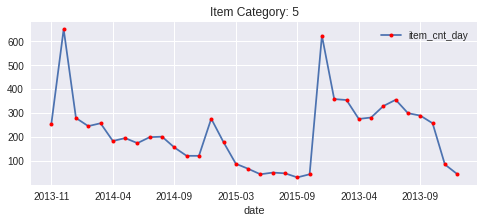

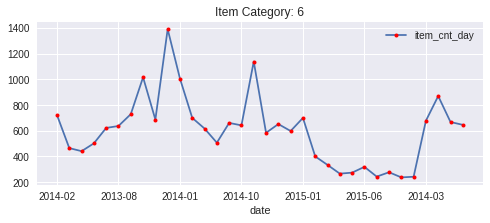

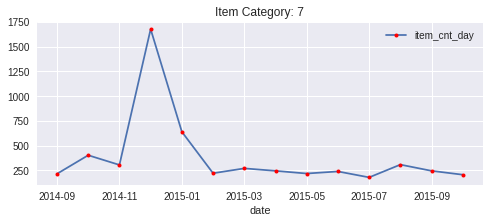

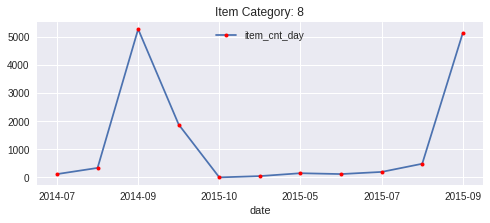

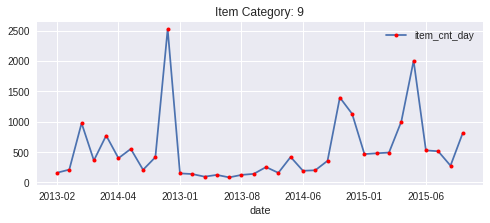

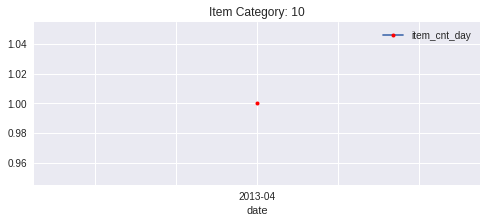

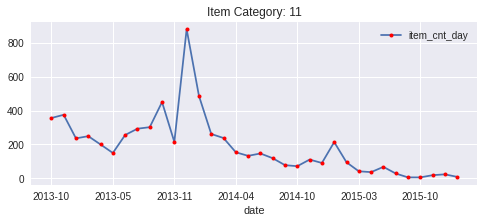

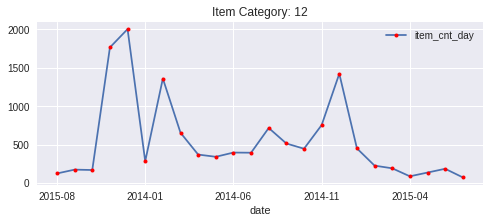

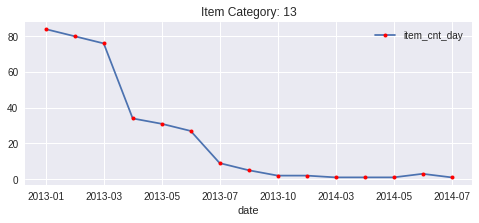

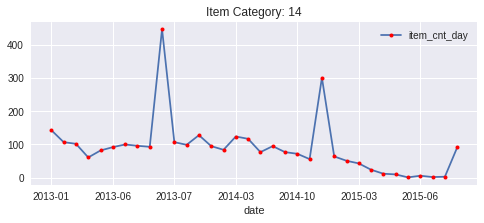

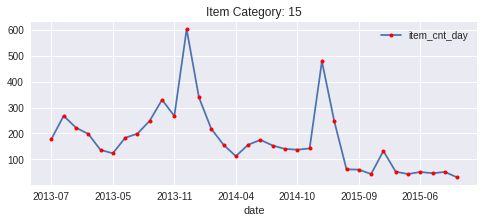

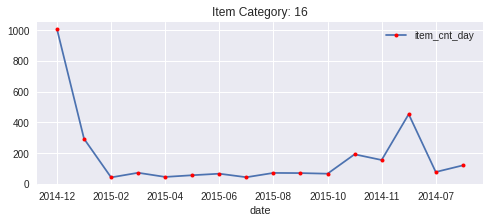

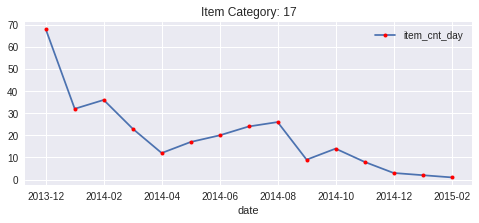

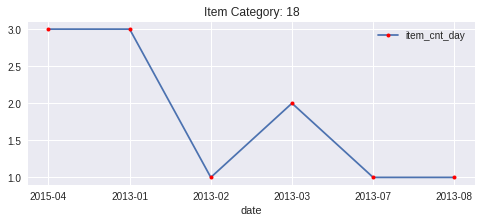

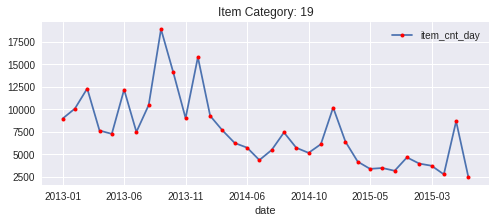

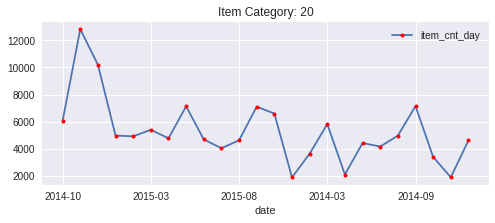

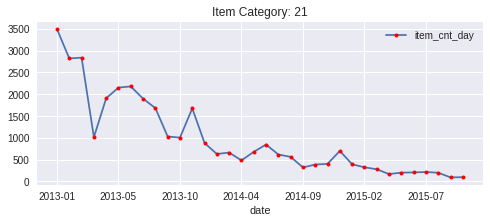

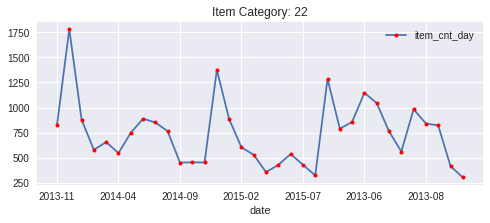

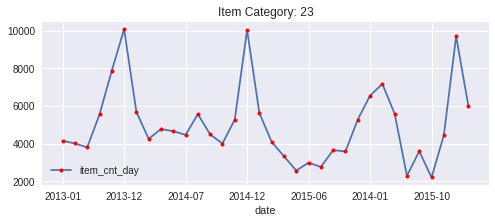

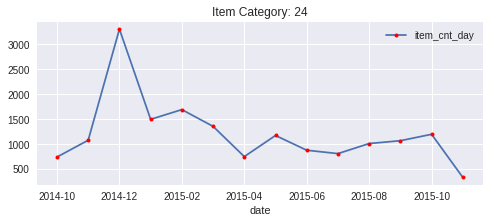

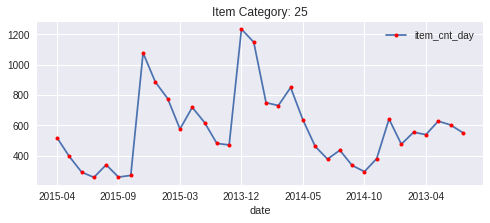

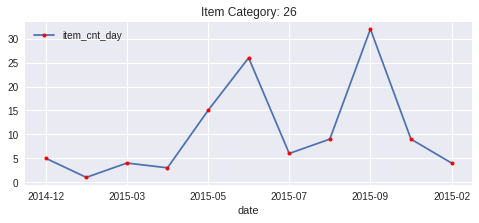

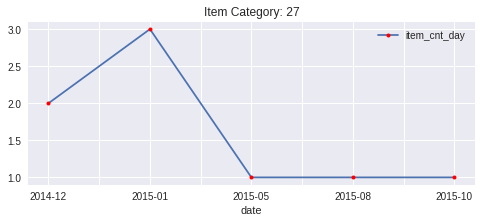

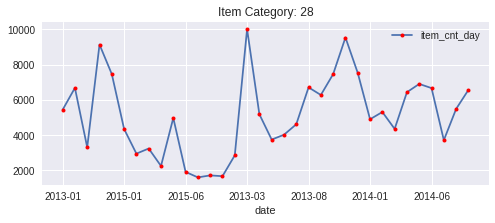

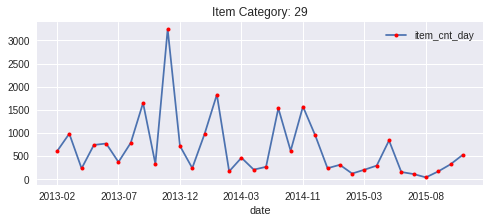

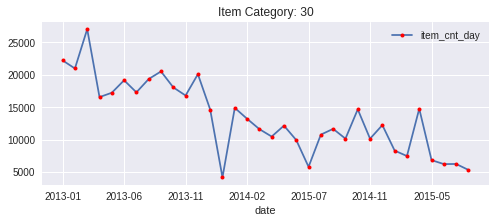

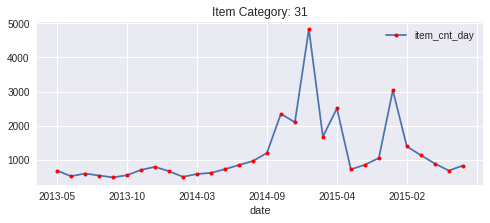

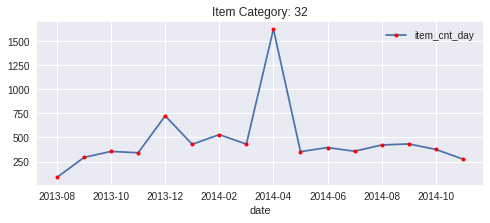

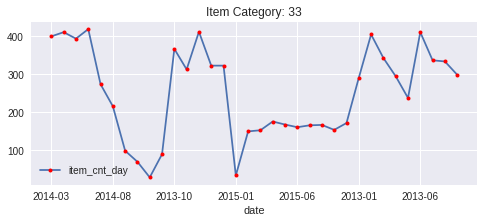

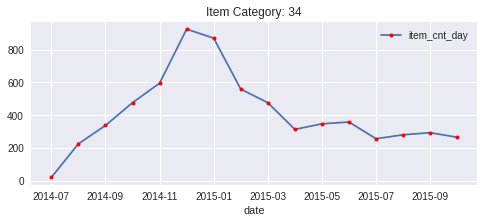

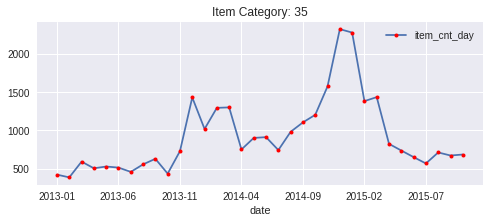

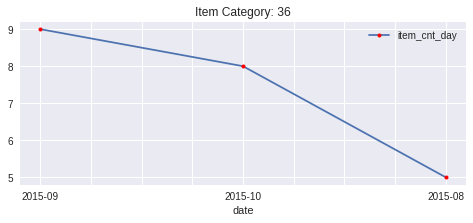

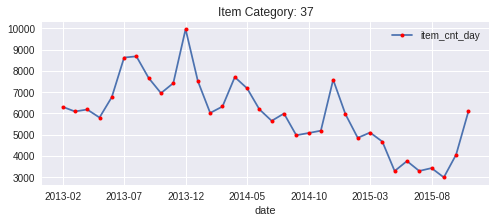

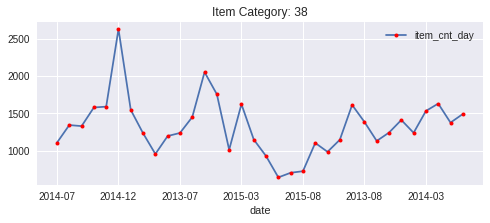

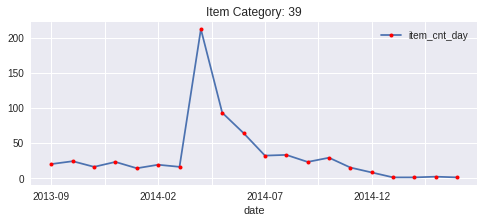

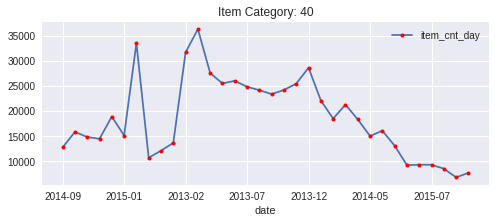

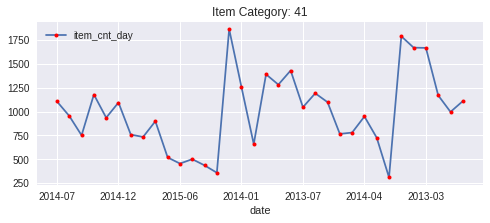

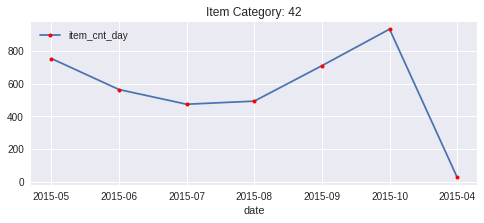

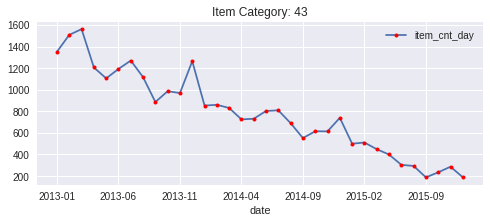

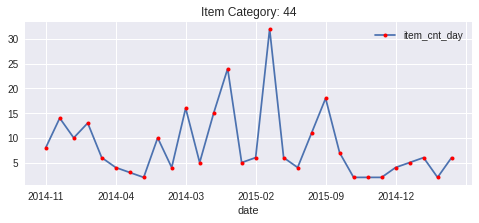

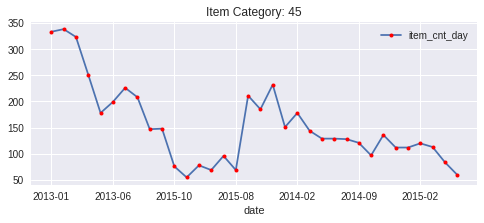

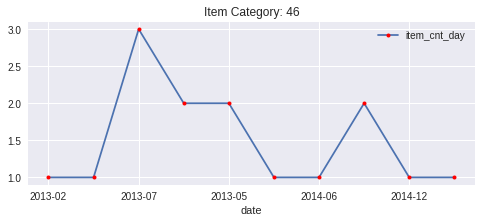

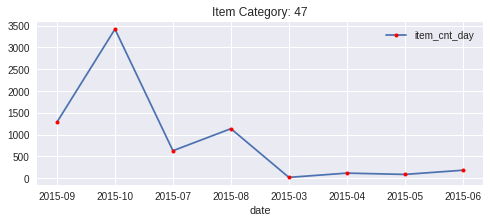

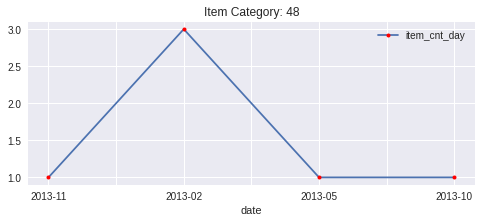

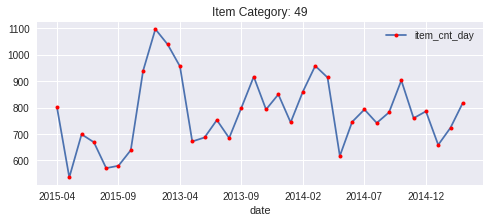

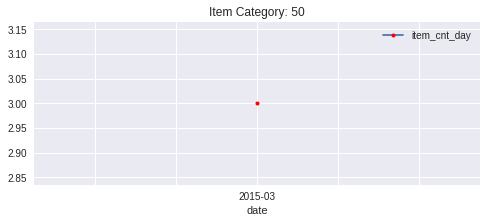

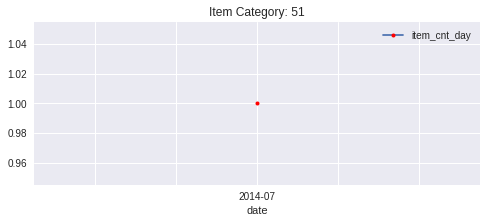

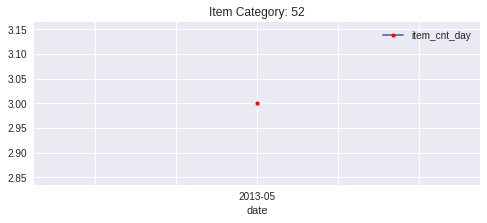

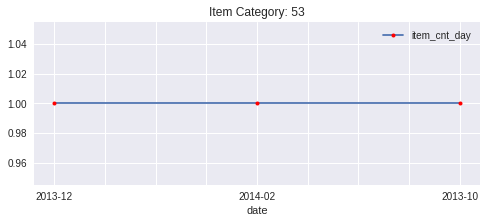

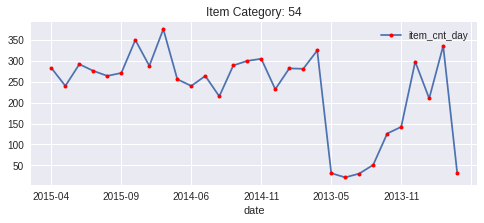

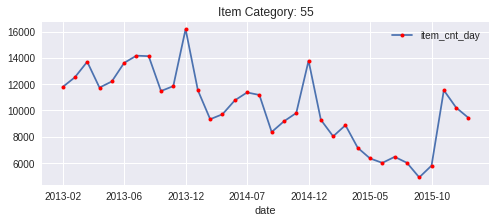

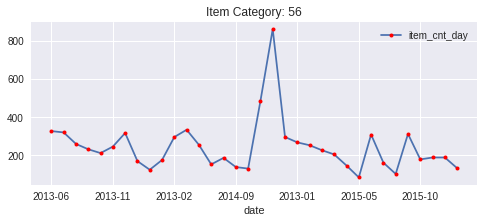

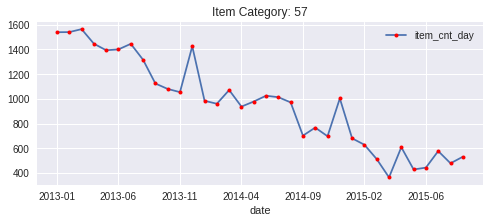

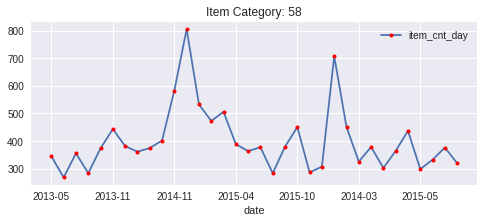

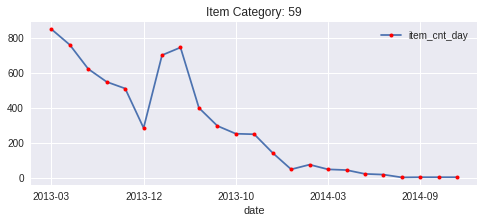

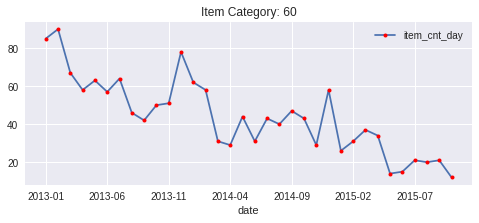

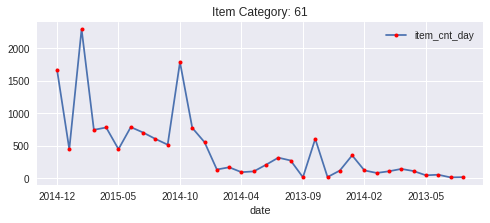

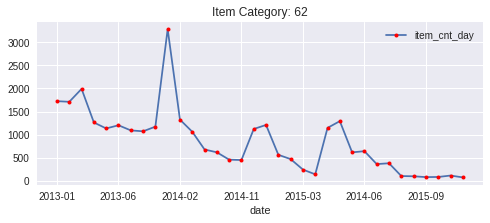

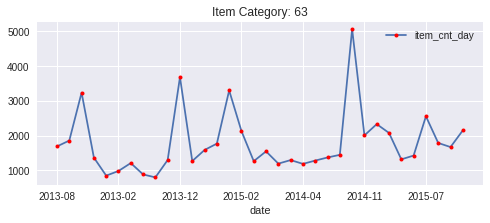

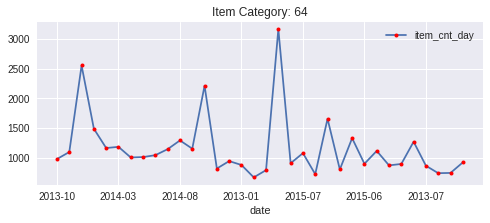

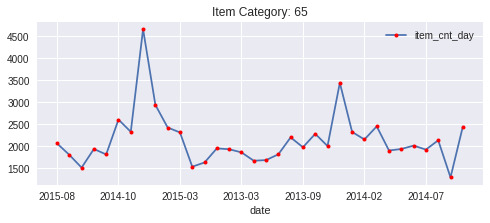

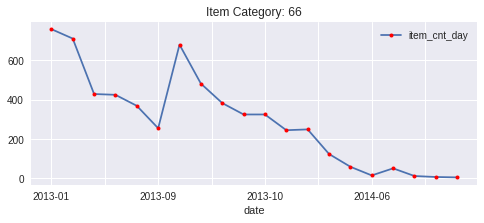

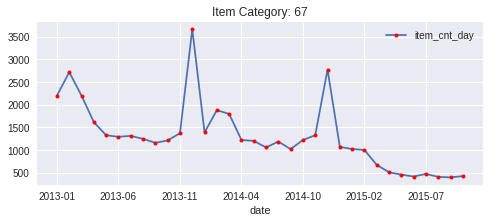

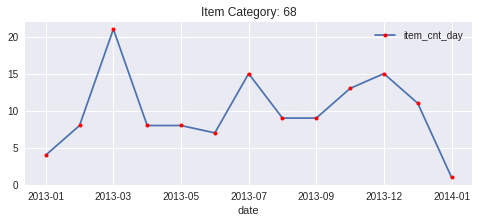

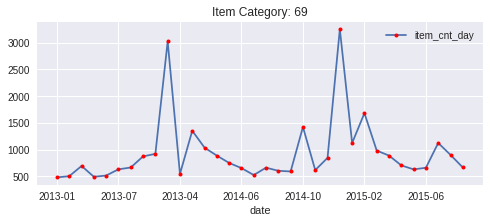

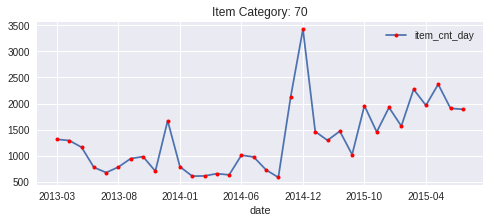

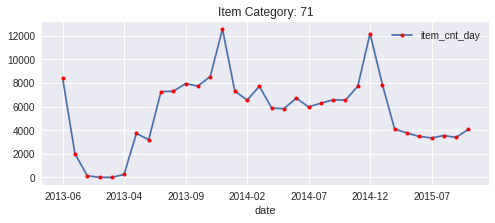

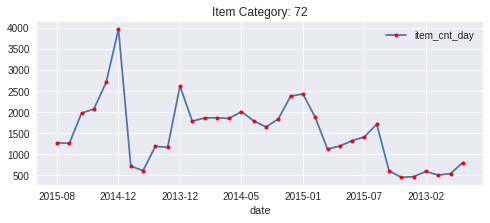

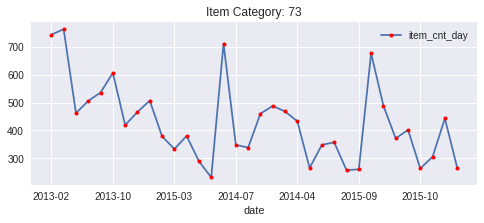

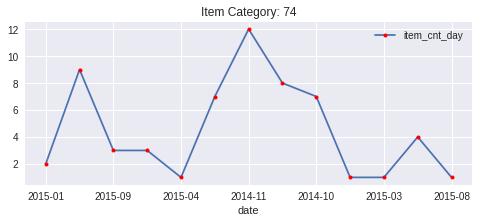

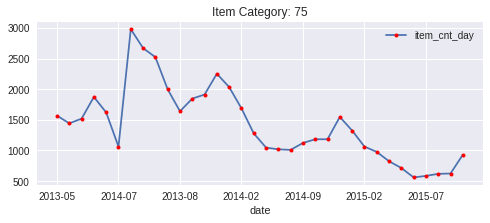

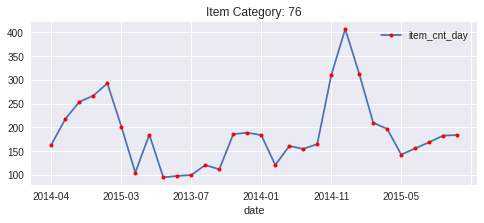

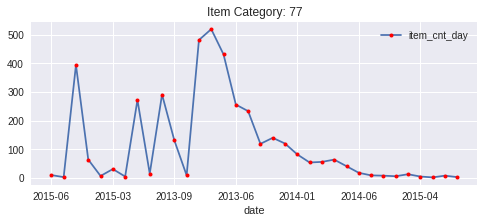

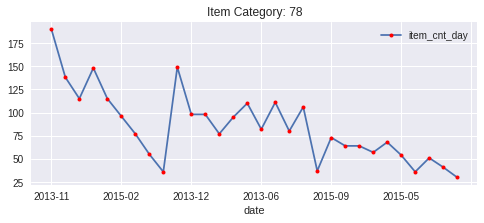

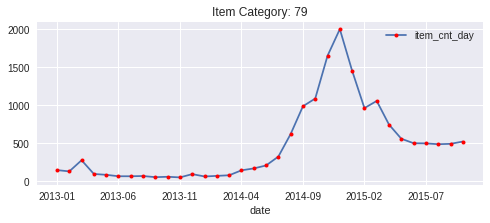

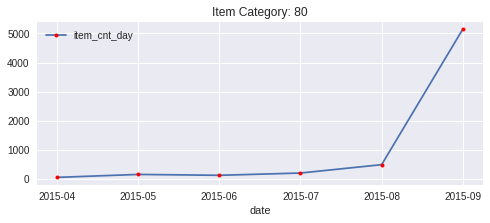

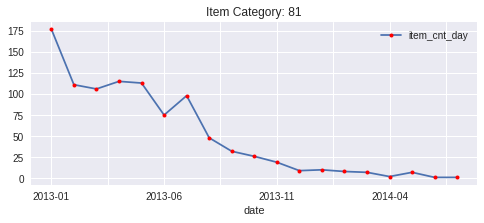

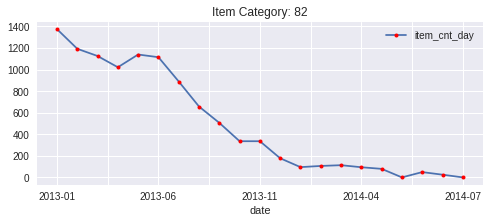

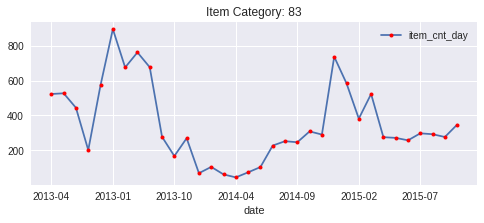

In [23]:
# remove the no longer used index in the df
df = df_all_sales_per_category_summed
df.reset_index(inplace=True, level=['item_category_id'])


df.head()

for category in df_item_categories:
    df_this_category = df.loc[df['item_category_id'] == category]
    df_this_category = df_this_category.drop(['item_category_id'], axis=1)
    plot = df_this_category.plot()
    plot.set_title(f"Item Category: {category}")



# Start a first train session

In [24]:
# overwrite df again as done previously
df = df_train.groupby(['date','shop_id','item_id']).sum()
df = df.pivot_table(index=['shop_id','item_id'], columns='date', values='item_cnt_day', fill_value=0)
df.reset_index(inplace=True)


# add more detail to the test dataframe
df_test = pd.merge(df_test, df, on=['shop_id','item_id'], how='left')
df_test.drop(['ID', '2013-01'], axis=1, inplace=True)
df_test = df_test.fillna(0)


# assign train and test from within the train set
# drop october 2015 from the set and assign it was test values
drop_year = '2015-10'
X_test = df_test
Y_train = df[drop_year].values
X_train = df.drop([drop_year], axis=1)

In [25]:
x_train, x_test, y_train, y_test = train_test_split( X_train, Y_train, test_size=0.20, random_state=1)

In [26]:
LR = LinearRegression()
LR.fit(x_train,y_train)

print('Train set mse:', mean_squared_error(y_train, LR.predict(x_train)))
print('Test set mse:', mean_squared_error(y_test, LR.predict(x_test)))
print('Test set score:', LR.score(x_train,y_train))

Train set mse: 11.035196010127326
Test set mse: 5.216807254420328
Test set score: 0.4383032716523845


In [ ]:
%time
RFR = RandomForestRegressor(n_estimators = 100)
RFR.fit(x_train,y_train)

print('Train set mse:', mean_squared_error(y_train, RFR.predict(x_train)))
print('Test set mse:', mean_squared_error(y_test, RFR.predict(x_test)))
print('Test set score:', RFR.score(x_train,y_train))

# this feels extremely overfitted

CPU times: user 26 µs, sys: 1e+03 ns, total: 27 µs
Wall time: 3.34 µs


In [ ]:
%time
XGB = XGBRegressor(max_depth=16,n_estimators=200,seed=1)
XGB.fit(x_train,y_train)

print('Train set mse:', mean_squared_error(y_train, XGB.predict(x_train)))
print('Test set mse:', mean_squared_error(y_test, XGB.predict(x_test)))
print('Test set score:', XGB.score(x_train,y_train))

# this feels extremely overfitted

In [ ]:
%time
LGBM = LGBMRegressor(max_depth=16,n_estimators=200,seed=1)
LGBM.fit(x_train,y_train)

print('Train set mse:', mean_squared_error(y_train, LGBM.predict(x_train)))
print('Test set mse:', mean_squared_error(y_test, LGBM.predict(x_test)))
print('Test set score:', LGBM.score(x_train,y_train))

In [ ]:
# predict using extreme gradiant boosting tree
prediction = XGB.predict(X_test)
# round the values to get integers
prediction = list(map(round, prediction))

In [ ]:
# map the submission file to the prediction
df_submission = pd.read_csv('data/technical/sample_submission.csv')
df_submission['item_cnt_month'] = prediction
df_submission.to_csv('prediction.csv', index=False)